# Code Along: FastAI DL L8 - Pascal Multi Object Detection

WNixalo - 2/5/2018

---

This notebook is a code along and warm up exercise. It follows the Fast.AI Deep Learning Lesson 9 Pascal Multi notebook. [Lecture](https://youtu.be/2HKbG7bGRIM?t=1529)|[Notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb)

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## 1. Setup

In [3]:
PATH = Path('../ext_data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [4]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, 
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH / trn_fns[i])
    draw_im(im, im_a)

## 2. Multi Class

[λecture9](https://youtu.be/2HKbG7bGRIM?t=1571)

In [7]:
MC_CSV = PATH/'tmp/mc.csv'

In [8]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [9]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [10]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [11]:
f_model = resnet34
sz = 224
bs = 64

In [12]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md   = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [13]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

epoch      trn_loss   val_loss   <lambda>                  
    0      1.392873   9.803486   0.6452    



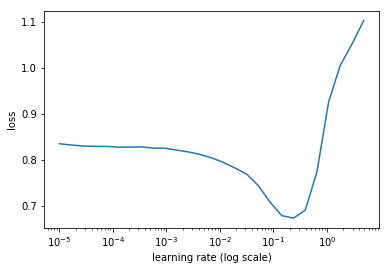

In [25]:
lrf = learn.lr_find(1e-5, 100)
learn.sched.plot(0)

In [26]:
lrs = 2e-2
learn.fit(lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.322777   0.132222   0.9572    
    1      0.171158   0.078847   0.9739                    
    2      0.116169   0.076086   0.9755                    



[array([0.07609]), 0.9754999985694885]

In [29]:
learn.fit(lrs/10, n_cycle=1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.065691   0.074703   0.9754    
    1      0.06162    0.074923   0.9756                     
    2      0.057844   0.075386   0.9748                     
    3      0.054527   0.074508   0.9758                     
    4      0.052355   0.074835   0.9751                     



[array([0.07484]), 0.9751000065803528]

In [30]:
learn.save('mclas')
# learn.load('mclas')

In [55]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


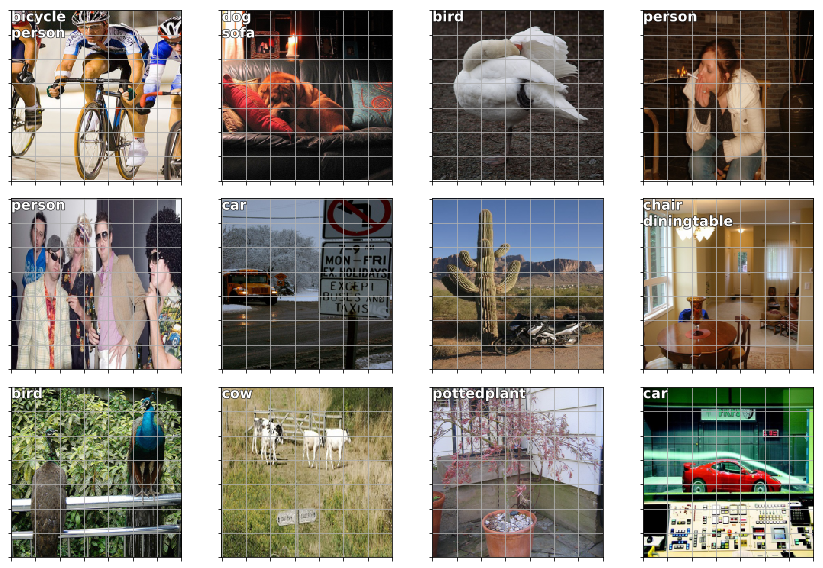

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0] # find actvn above a threshold
    b  = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## 3. Bounding Box per Cell

[λecture9](https://youtu.be/2HKbG7bGRIM?t=1749)

### 3.1 Set up Data

In [14]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV  = PATH/'tmp/mbb.csv'

f_model = resnet34
sz = 224
bs = 64

In [15]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [16]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [17]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox':mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [18]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [19]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD), 
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md   = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [20]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [21]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1, 4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i, (b,c,pr) in enumerate(zip(bb, clas, prs)):
        if ((b[2] > 0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i % num_colr])
            txt = f'{i}: '
            if c is not None:  txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i % num_colr])

In [22]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [23]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [35]:
# x,y = to_np(next(iter(md.val_dl)))
# x = md.val_ds.ds.denorm(x)

x,y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


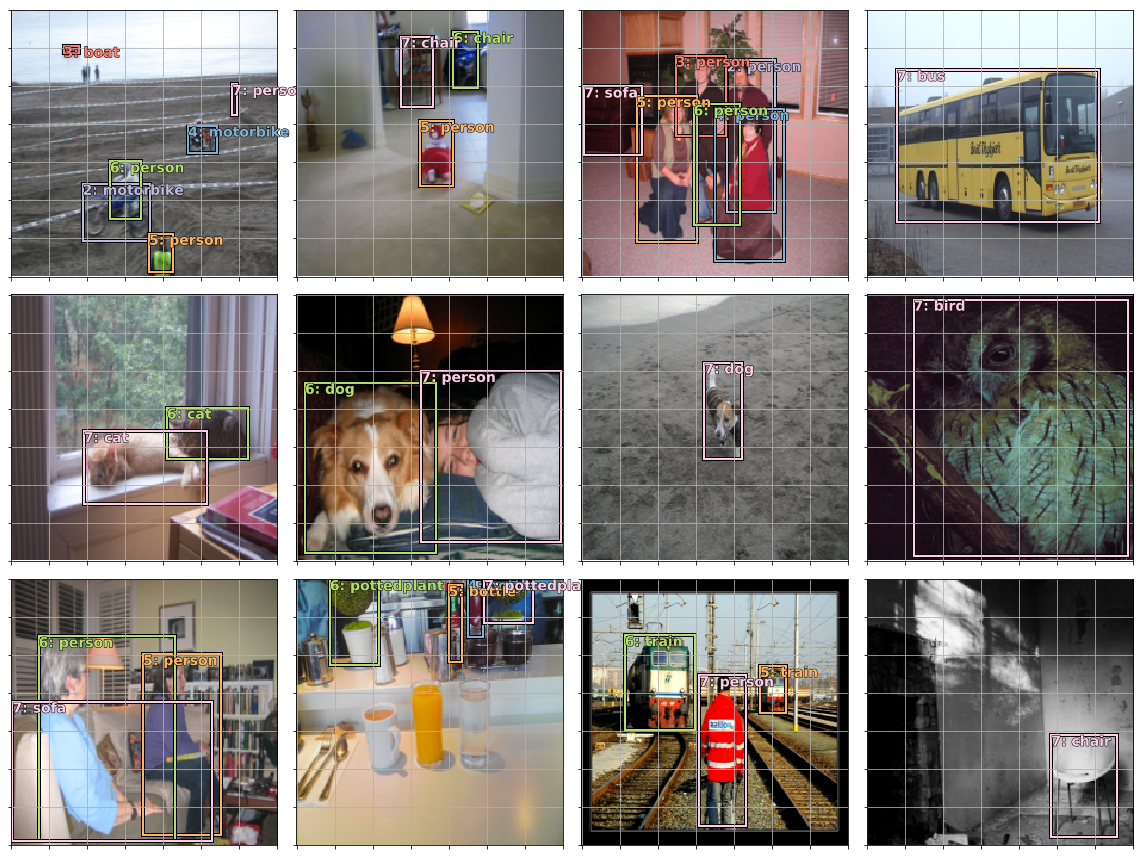

In [36]:
fig,axes = plt.subplots(3, 4, figsize=(16,12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### 3.2 Set up Model

In [45]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors  = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [46]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [47]:
# plt.scatter(anc_x, anc_y)
# plt.xlim(0, 1)
# plt.ylim(0, 1);

In [48]:
# anchors

In [49]:
def hw2corners(ctr, hw): return torch.cat([ctr - hw/2, ctr + hw/2], dim=1)

In [50]:
anchor_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])
# anchor_cnr

In [51]:
n_clas = len(id2cat) + 1
n_act  = k*(4 + n_clas)

In [52]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf // k)

In [53]:
class OutConv(nn.Module): # 2 separate output conv layers: bbx reg & clsfn
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]

In [54]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1) # stride 1 doesnt change geometry while adding a computation layer
#         self.sconv1 = StdConv(256, 256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)
    
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn  = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### 3.3 Training

[λecture9](https://youtu.be/2HKbG7bGRIM?t=4159)

In [55]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = V(t[:, :-1].contiguous())#.cpu() # remove last col (bg)
        x = pred[:, :-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self, x, t): return None
    
loss_f = BCE_Loss(len(id2cat))

In [56]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [57]:
def get_y(bbox, clas): # strip fastai zero padding
    bbox = bbox.view(-1, 4) / sz
    bb_keep = ((bbox[:,2] - bbox[:,0]) > 0).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:, :2] / 2 * grid_sizes) + anchors[:, :2]
#     pdb.set_trace()
    actn_hw = (actn_bbs[:, 2:] / 2 + 1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False): # calc ssd loss for 1 img
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors) # cnvt activations to bboxs
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:, 0] # find what matches
    gt_clas[1 - pos] = len(id2cat) # asign bg class
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean() # L1 loss
    clas_loss = loss_f(b_c, gt_clas) # BCE loss
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    λcs,λλs = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ): # loop thru ea. img in minibatch
        loc_loss,clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        λλs += loc_loss
        λcs += clas_loss
    if print_it: print(f'loc: {λλs.data[0]}, clas: {λcs.data[0]}')
    return λλs+λcs

In [58]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [59]:
# for i,o in enumerate(y): y[i] = o.cpu()
# learn.model.cpu();

In [60]:
batch = learn.model(x)

In [61]:
# anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [62]:
ssd_loss(batch, y, False)

Variable containing:
 83.9688
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [63]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100, lr/10, lr])

  0%|          | 0/32 [00:00<?, ?it/s]
epoch      trn_loss   val_loss                            
    0      91.149372  377702.583



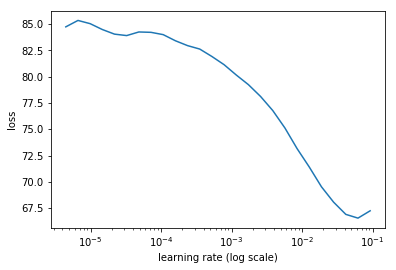

In [206]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(1)

In [207]:
learn.fit(lr, n_cycle=1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      43.1795    34.210306 
    1      33.61997   28.31672                            
    2      29.211345  27.30378                            
    3      26.436654  26.140986                           
    4      24.167     25.739712                           



[array([25.73971])]

In [208]:
learn.save('0')
# learn.load('0')

### 3.4 Testing

In [64]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [65]:
b_clas.size(), b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [66]:
idx=6
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima = md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
# bbox,clas

In [67]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
        to_np(clas), to_np(prs) if prs is not None else None, thresh)

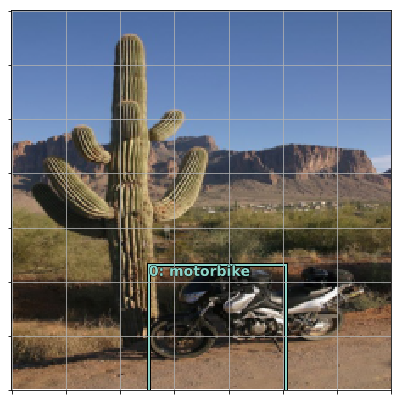

In [247]:
fig,ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

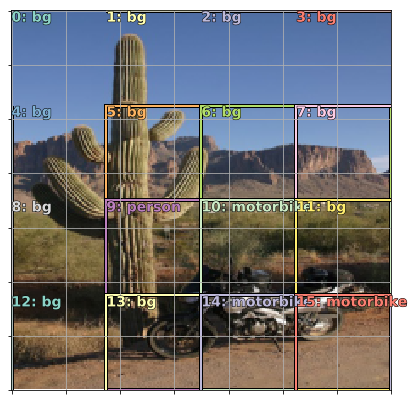

In [248]:
fig,ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [ ]:
# grid_sizes

In [ ]:
# anchors

In [68]:
a_ic = actn_to_bb(b_bboxi, anchors)

In [47]:
# fig,ax = plt.subplots(figsize=(7,7))
# torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [69]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
# overlaps

In [ ]:
# overlaps.max(1)

In [ ]:
# overlaps.max(0)

In [70]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
# gt_overlap, gt_idx

In [71]:
gt_clas = clas[gt_idx]
# gt_clas

In [72]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1 - pos)[:,0]
# pos_idx

In [73]:
gt_clas[1 - pos] = len(id2cat)
# [id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

In [74]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss = F.cross_entropy(b_clasi, gt_clas)
# loc_loss,clas_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


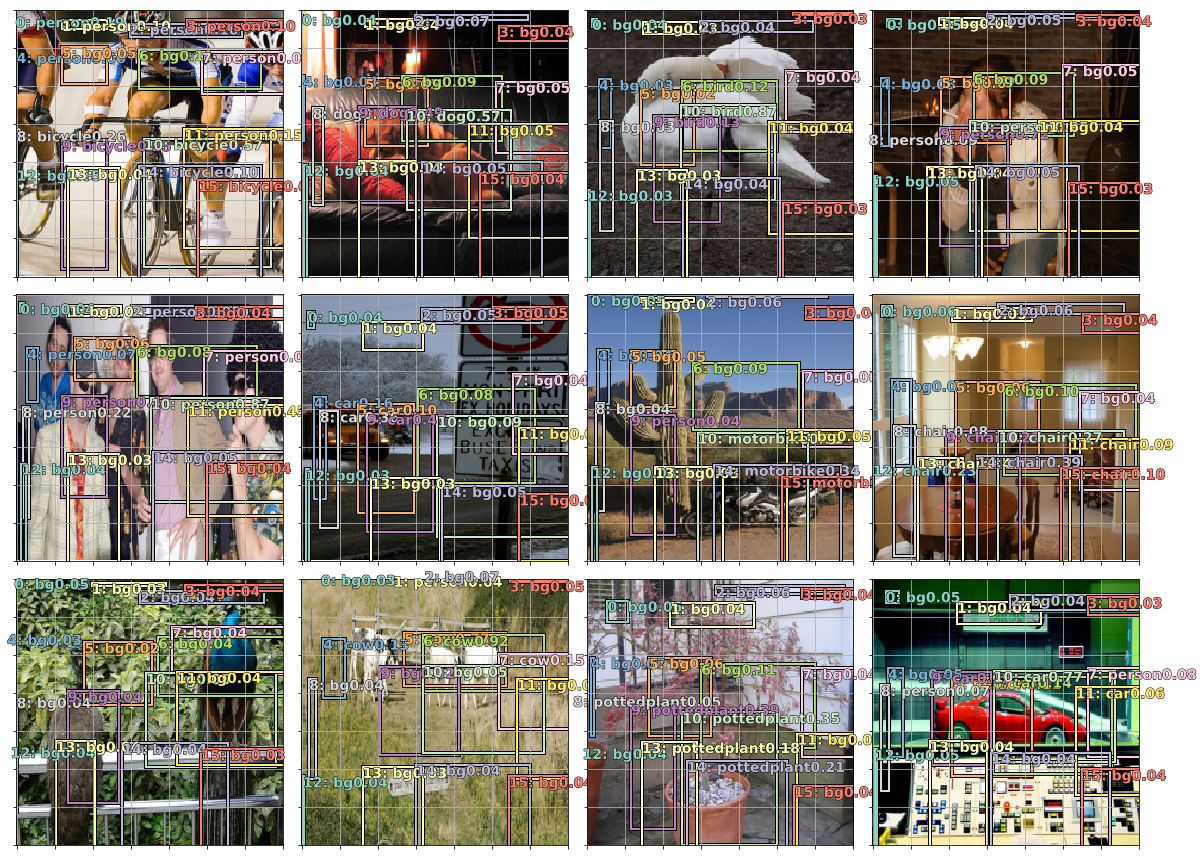

In [234]:
fig,axes = plt.subplots(3, 4, figsize=(16,12))
for idx,ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## 4. More Anchors

[λecture9](https://youtu.be/2HKbG7bGRIM?t=4485)

### 4.1 Create Anchors

In [75]:
anc_grids = [4,2,1] # size levels of anchors
# anc_grids = [2]
# anc_zooms = [0.75, 1., 1.3] # zoom levels of anchors
anc_zooms = [1.]
# anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)] # aspect ratios of anchors
anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

1

In [76]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) 
                       for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) 
                       for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [77]:
anc_sizes  =  np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) 
                                        for o,p in anchor_scales])
                              for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([1/ag       for i in range(ag*ag) 
                                        for o,p in anchor_scales])
                              for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors    = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [78]:
x,y = to_np(next(iter(md.val_dl)))
x   = md.val_ds.ds.denorm(x)

In [79]:
a = np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

`anc_grids = [4,2,1]
anc_zooms = [1.]
anc_ratios = [(1.,1.)]`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


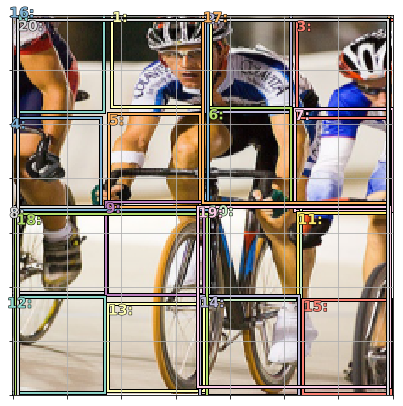

In [70]:
fig,ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

### 4.2 Model

In [80]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512, 256, drop=drop) # stride 2 conv halves grid size
        self.sconv2 = StdConv(256, 256, drop=drop)
        self.sconv3 = StdConv(256, 256, drop=drop)
        self.out0 = OutConv(k, 256, bias) # dont think this is used
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x) # 4x4 anchor size
        o1c,o1λ = self.out1(x) # grab outputs (anchors)
        x = self.sconv2(x) # 2x2
        o2c,o2λ = self.out2(x)
        x = self.sconv3(x) # 1x1
        o3c,o3λ = self.out3(x)
#         return [o1c,o1λ]
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1λ,o2λ,o3λ], dim=1)]

head_reg4 = SSD_MultiHead(k, -4)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [81]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100, lr/10, lr])

In [82]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [83]:
batch[0].size(), batch[1].size()

(torch.Size([64, 21, 21]), torch.Size([64, 21, 4]))

In [84]:
ssd_loss(batch, y, False)

Variable containing:
 63.1434
[torch.cuda.FloatTensor of size 1 (GPU 0)]

epoch      trn_loss   val_loss                            
    0      86.703362  46219.018719



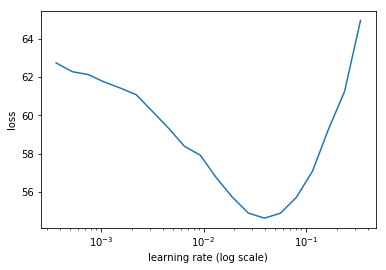

In [340]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(n_skip_end=2)

In [341]:
learn.fit(lrs, n_cycle=1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                            
    0      42.082747  39.225438 
    1      36.100369  30.505003                           
    2      31.871631  28.58201                            
    3      28.560662  26.548393                           



[array([26.54839])]

In [342]:
learn.save('tmp')

In [343]:
learn.freeze_to(-2)
learn.fit(lrs/2, n_cycle=1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                            
    0      28.566661  30.943751 
    1      26.197743  26.814818                           
    2      22.969703  25.04589                            
    3      20.00638   23.390348                           



[array([23.39035])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


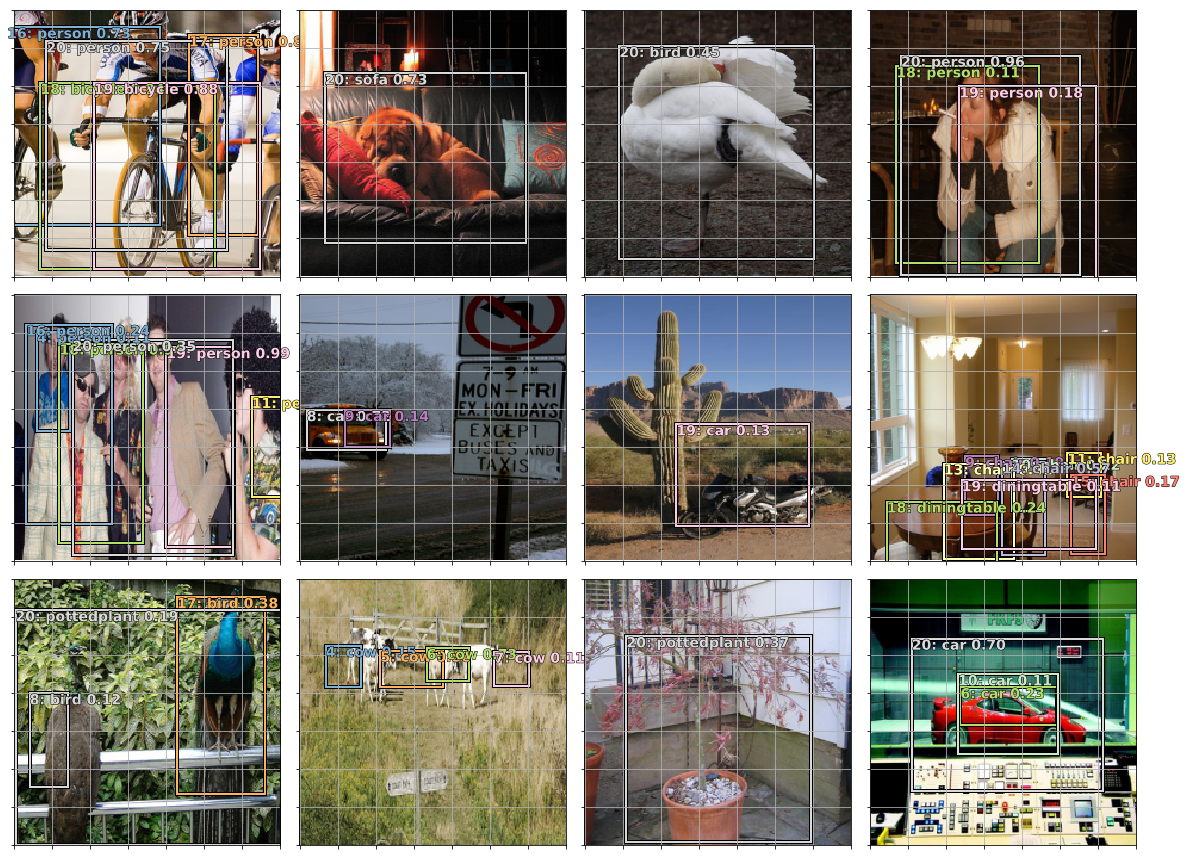

In [345]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig,axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.1)
plt.tight_layout()

## 5. Focal Loss

[λecture9](https://youtu.be/2HKbG7bGRIM?t=6623) | [theory](https://youtu.be/2HKbG7bGRIM?t=5940)

In [85]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch
    
    x = to_np(x)
    fig,axes = plt.subplots(3, 4, figsize=(16,12))
    for idx,ax in enumerate(axes.flat):
        ima = md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr,clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [86]:
class FocalLoss(BCE_Loss):
    def get_weight(self, x, t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    
loss_f = FocalLoss(len(id2cat))

In [89]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, False)

Variable containing:
 14.8242
[torch.cuda.FloatTensor of size 1 (GPU 0)]

epoch      trn_loss   val_loss                            
    0      37.04348   156399.911375



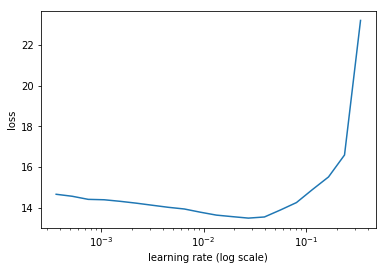

In [89]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(n_skip_end=2)

In [90]:
learn.fit(lrs, n_cycle=1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      11.400052  13.710236 
    1      10.507085  9.447837                            
    2      9.609456   8.379604                            
    3      8.865045   8.094599                            
    4      8.240749   7.477089                            
    5      7.653023   7.242845                            
    6      7.202938   6.927003                            
    7      6.838497   6.767965                            
    8      6.54662    6.621925                            
    9      6.266423   6.529661                            



[array([6.52966])]

In [90]:
# learn.save('fλ0')
learn.load('fλ0')

In [91]:
learn.freeze_to(-2)
learn.fit(lrs/4, n_cycle=1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      6.155651   6.633955  
    1      6.083202   6.464079                            
    2      5.875623   6.301223                            
    3      5.623336   6.001045                            
    4      5.334935   5.887683                            
    5      5.045238   5.855156                            
    6      4.793303   5.771457                            
    7      4.559295   5.688029                            
    8      4.352319   5.657485                            
    9      4.196937   5.605956                            



[array([5.60596])]

In [92]:
learn.save('drop4')
# learn.load('drop4')

In [93]:
learn.unfreeze()
learn.fit(lrs/16, n_cycle=1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      3.982025   5.659951  
    1      3.934011   5.670829                            
    2      3.885993   5.686977                            
    3      3.812629   5.630007                            
    4      3.747042   5.63697                             
    5      3.676256   5.629119                            
    6      3.61559    5.650269                            
    7      3.554628   5.644168                            
    8      3.507753   5.639403                            
    9      3.432487   5.623223                            



[array([5.62322])]

In [94]:
learn.save('focal_fin')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


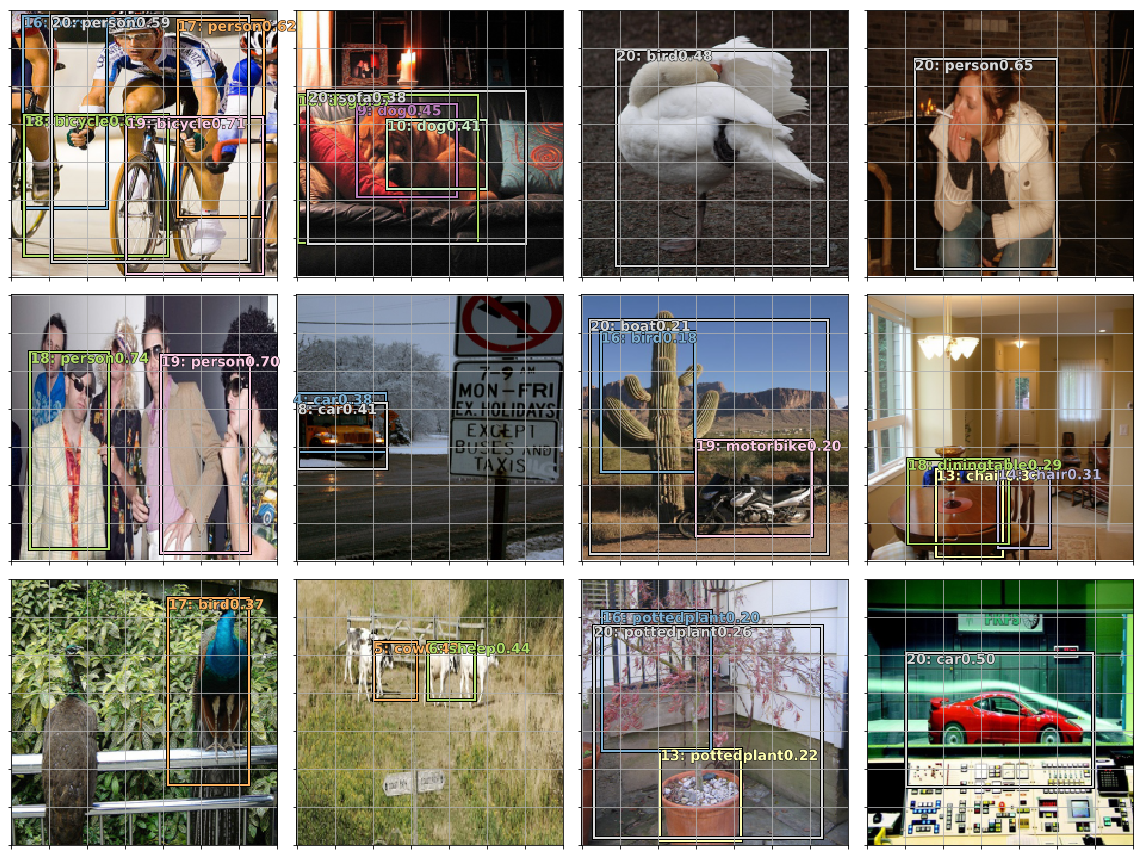

In [95]:
plot_results(0.75)

## Z. End